In [1]:
from ts2vg import NaturalVG, HorizontalVG
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
ohlcv = pd.read_csv("../data/a.us.txt").set_index("Date")
price = ohlcv["Close"]
price = price.iloc[-365:]
g = HorizontalVG(weighted="distance")
g.build(price)
nx_g = g.as_networkx()  
nx_g

In [3]:
print(len(nx_g.nodes), len(nx_g.edges))

365 656


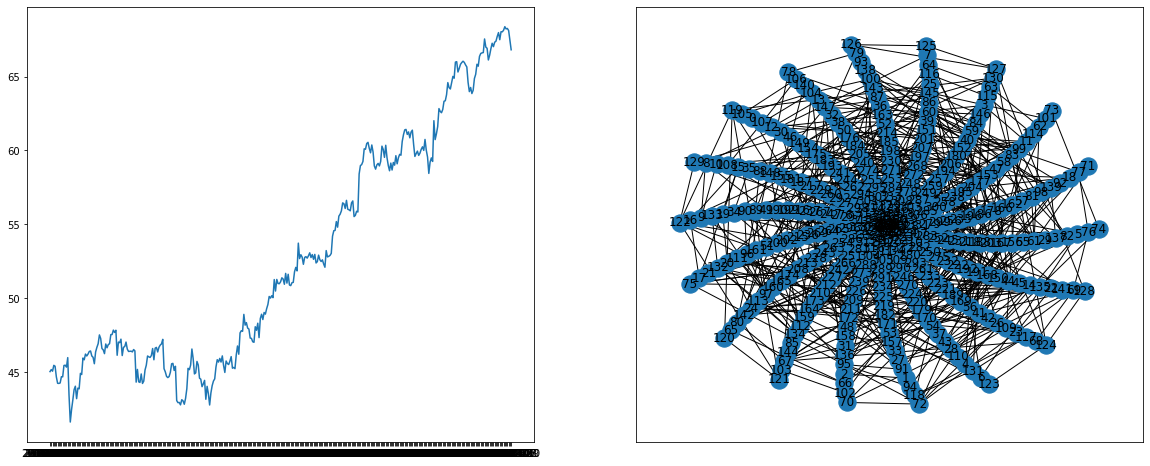

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(price)
pos = nx.spiral_layout(nx_g)
nx.draw_networkx(nx_g, pos=pos, ax=axes[1])

In [5]:
import torch
from torch_geometric.utils.convert import from_networkx
data = from_networkx(nx_g)
data.x = torch.ones((data.num_nodes, ))
data
print(data.num_node_features, data.num_features)

1 1


In [6]:
nx.degree_histogram(nx_g)

[0, 2, 121, 88, 65, 39, 26, 12, 6, 3, 1, 1, 0, 1]

In [7]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader

In [9]:
import torch.functional as F
class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

cuda


AttributeError: 'GlobalStorage' object has no attribute 'num_classes'

In [ ]:
model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print(f"Accuracy: {acc}")